# Figure 2a - Different cell sizes for discretizing the fixed-size metal infrastructure

In [1]:
from SimPEG import  maps, utils
import SimPEG.electromagnetics.time_domain as tdem
from discretize import TreeMesh
from discretize.utils import mkvc, refine_tree_xyz, active_from_xyz
import empymod
import numpy as np
from scipy.constants import mu_0
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm
from matplotlib import animation, collections

try:
    from pymatsolver import Pardiso as Solver
except:
    from SimPEG import SolverLU as Solver

import sys
# sys.path.append("..")  # 添加上一级目录到sys.path
# from utils import  simulation # 导入module模块
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

C:\Users\RS\AppData\Local\Temp\ipykernel_35960\1309131080.py:1: FutureWarning: Importing `SimPEG` is deprecated. please import from `simpeg`.
  from SimPEG import  maps, utils


In [2]:
# setting the loop location
def get_loop_location(length, angle, offset):

    """
    Get the loop location based on the length and angle
    """
    delta = offset / 2
    locations = []

    # if angle < 90:
    x = length / 2
    y = (length / 2) * np.sin(np.deg2rad(angle))
    z = (length / 2) * np.cos(np.deg2rad(angle))

    locations.append([-delta-x, -y,  z])
    locations.append([-delta+x, -y,  z])
    locations.append([-delta+x,  y, -z])
    locations.append([-delta-x,  y, -z])
    locations.append([-delta-x, -y,  z])

    return np.array(locations)


In [ ]:
def mesh_d(offset, orientation, distance, cell):
    delta = offset / 2
    dh = cell  # base cell width
    # dom_width = 5000.0  # domain width
    dom_width = 10000
    nbc = 2 ** int(np.round(np.log(dom_width / dh) / np.log(2.0)))  # num. base cells

    # Define the base mesh
    h = [(dh, nbc)]
    mesh = TreeMesh([h, h, h], x0="CCC")

    # for i in range(100):
    x_low = -0.3 
    x_high = 0.3
    # ——————————————————————————y-left——————————————————————————————————
    xp, yp, zp = np.meshgrid([x_low, x_high], [-2.5, -2.3], [-2.5, 2.5])
    xyz = np.c_[mkvc(xp), mkvc(yp), mkvc(zp)]
    mesh = refine_tree_xyz(mesh, xyz, octree_levels=[0, 2], method="box", finalize=False)

    # ——————————————————————————y-right——————————————————————————————————
    xp, yp, zp = np.meshgrid([x_low, x_high], [2.4, 2.6], [-2.5, 2.5])
    xyz = np.c_[mkvc(xp), mkvc(yp), mkvc(zp)]
    mesh = refine_tree_xyz(mesh, xyz, octree_levels=[0, 2], method="box", finalize=False)

    # ——————————————————————————z-upper——————————————————————————————————
    xp, yp, zp = np.meshgrid([x_low, x_high], [-2.5, 2.5], [2.32, 2.5])
    xyz = np.c_[mkvc(xp), mkvc(yp), mkvc(zp)]
    mesh = refine_tree_xyz(mesh, xyz, octree_levels=[0, 2], method="box", finalize=False)

    # # ——————————————————————————z-lower——————————————————————————————————
    xp, yp, zp = np.meshgrid([x_low, x_high], [-0.7], [-2.4, -2.3])
    xyz = np.c_[mkvc(xp), mkvc(yp), mkvc(zp)]
    mesh = refine_tree_xyz(mesh, xyz, octree_levels=[0, 2], method="box", finalize=False)

    xp, yp, zp = np.meshgrid([x_low, x_high], [0.7], [-2.4, -2.3])
    xyz = np.c_[mkvc(xp), mkvc(yp), mkvc(zp)]
    mesh = refine_tree_xyz(mesh, xyz, octree_levels=[0, 2], method="box", finalize=False)

    # # ——————————————————————————Receiver——————————————————————————————————
    # xp, yp, zp = np.meshgrid([0.0, 0.5], [0, 0], [0, 0])
    receiver_locations = np.array([[delta, 0, 0]])

    # Mesh refinement near transmitters and receivers
    mesh = refine_tree_xyz(
        mesh, receiver_locations, octree_levels=[2, 4], method="radial", finalize=False
    )

    if orientation == 'x':
        source_locations = np.array([
            [-delta, -0.5, 0.5], [-delta, 0.5, 0.5], 
            [-delta, 0.5, -0.5], [-delta, -0.5, -0.5],
            [-delta, -0.5, 0.5]])
        
    elif orientation == 'y':
        source_locations = np.array([
            [-delta-0.5, 0, 0.5], [-delta+0.5, 0, 0.5], 
            [-delta+0.5, 0, -0.5], [-delta-0.5, 0, -0.5],
            [-delta-0.5, 0, 0.5]])
    elif orientation == 'z':
        source_locations = np.array([
            [-delta-0.5, -0.5, 0], [-delta-0.5, 0.5, 0], 
            [-delta+0.5, 0.5, 0], [-delta+0.5, -0.5, 0],
            [-delta-0.5, -0.5, 0]])
    else:
        print('orientation error')
        return

    mesh = refine_tree_xyz(
        mesh, source_locations, octree_levels=[2, 4], method="radial", finalize=False
    )

    # # ——————————————————————————异常体区域加密——————————————————————————————————
    # x1, y1, z1 = 0, distance+25, 0
    # abnormal_locations = np.array(
    #     [[x1, y1, z1], 
    #     [x1-25, y1-25, z1+25], [x1-25, y1-25, z1-25], 
    #     [x1+25, y1-25, z1+25], [x1+25, y1-25, z1-25],
    #     [x1-25, y1+25, z1+25], [x1-25, y1+25, z1-25], 
    #     [x1+25, y1+25, z1+25], [x1+25, y1+25, z1-25]])
    # # Mesh refinement near transmitters and receivers
    # mesh = refine_tree_xyz(
    #     mesh, abnormal_locations, octree_levels=[2, 4], method="radial", finalize=False
    # )

    mesh.finalize()

    return mesh, source_locations, receiver_locations#, abnormal_locations[0]

In [4]:
def get_model_frame_rail(mesh, sigma_half, sigma_frame, sigma_rail, mu_r, sigma_block, sigma_air, thickness):
    # thickness = 0.2

    model = np.ones(mesh.nC) * sigma_half
    mur = np.ones(mesh.nC)

    ################layer####################
    layer = ((mesh.gridCC[:,0] >= -1) & (mesh.gridCC[:,0] <= 1) & 
            (mesh.gridCC[:,1] >= -2.5) & (mesh.gridCC[:,1] <= 2.5) &
            (mesh.gridCC[:,2] >= -2.5) & (mesh.gridCC[:,2] <= 2.5))

#     rail1 = ((mesh.gridCC[:,0] >= -50) & (mesh.gridCC[:,0] <= 50) & 
#             (mesh.gridCC[:,1] >= -0.9) & (mesh.gridCC[:,1] <= -0.9 + thickness) &
#             (mesh.gridCC[:,2] >= -2.5) & (mesh.gridCC[:,2] <= -2.5 + thickness))

#     rail2 = ((mesh.gridCC[:,0] >= -50) & (mesh.gridCC[:,0] <= 50) & 
#             (mesh.gridCC[:,1] >= 0.9 - thickness) & (mesh.gridCC[:,1] <= 0.9) &
#             (mesh.gridCC[:,2] >= -2.5) & (mesh.gridCC[:,2] <= -2.5 + thickness))
    model[layer] = sigma_half#sigma_air
    mur[layer] = 1  


    ################ interference ####################
#     n = -50
#     for i in range(100):
    n = thickness / 2
    layer_1 =   ((mesh.gridCC[:,0] >= -n) & (mesh.gridCC[:,0] <= n) & 
                    (mesh.gridCC[:,1] >= -2.5) & (mesh.gridCC[:,1] <= 2.5) &
                    (mesh.gridCC[:,2] >= -2.5) & (mesh.gridCC[:,2] <= 2.5))
    model[layer_1] = sigma_frame
    mur[layer_1] = mu_r

        # n = n + 1

    layer_2 =   ((mesh.gridCC[:,0] >= -1) & (mesh.gridCC[:,0] <= 1) & 
                    (mesh.gridCC[:,1] >= -2.5 + thickness) & (mesh.gridCC[:,1] <= 2.5 - thickness) &
                    (mesh.gridCC[:,2] >= -2.5) & (mesh.gridCC[:,2] <= 2.5 - thickness))
    model[layer_2] = sigma_half#sigma_air
    mur[layer_2] = 1


#     model[rail1] = sigma_rail
#     model[rail2] = sigma_rail
#     mur[rail1] = mu_r
#     mur[rail2] = mu_r
    
    ################ abnormal ####################
    # block = (
    #     (mesh.gridCC[:,0] >= center[0]-25) & (mesh.gridCC[:,0] <= center[0]+25) & 
    #     (mesh.gridCC[:,1] >= center[1]-25) & (mesh.gridCC[:,1] <= center[1]+25) & 
    #     (mesh.gridCC[:,2] >= center[2]-25) & (mesh.gridCC[:,2] <= center[2]+25))
    # model[block] = sigma_block

    fig = plt.figure(figsize=(10,10), dpi=100)
    plt.subplot(221)
    ax = plt.gca()
    # mesh.plot_3d_slicer(np.log10(model), zslice = 0, fig=fig, 
    #                     xlim=[-10, 10], ylim=[-10, 10], zlim=[-10, 10],
    #                     )
    dat2 = mesh.plotSlice(np.log10(model), grid= False , ax=ax, normal='x')
#     ax.grid(linewidth=2)  # 设置网格线的粗细为2
#     ax.set_xlim([-100,100])
#     ax.set_ylim([-100,100])
    ax.set_xlim([-3,3])
    ax.set_ylim([-3,3])
    ax.set_title("Conductivity profile at X = 0")
    ax.set_xlabel("Y / m", fontsize=12)
    ax.set_ylabel("Z / m", fontsize=12)
    ax.tick_params(labelsize=12)

    plt.subplot(222)
    ax = plt.gca()
    dat2 = mesh.plotSlice(np.log10(model), grid= True , ax=ax,  normal='y')
    ax.set_xlim([-0.5, 0.5])
    ax.set_ylim([2,3])
    ax.set_title("Conductivity profile at Y = 0")
    ax.set_xlabel("X / m", fontsize=12)
    ax.set_ylabel("Z / m", fontsize=12)
    ax.tick_params(labelsize=12)

    return model, mur

In [5]:
def forward(mesh, model, mur, source_locations, receiver_locations,  path):
    times = np.logspace(np.log10(1e-6), np.log10(1e-2), 300)
    rec_list = []
    for i in ["x", "y", "z"]:
        rec_list.append(tdem.Rx.PointMagneticFluxTimeDerivative(
                    orientation = i,
                    times=times,
                    locations=receiver_locations[0])
                    )

    # Set up the source list
    src_list = [
        tdem.Src.LineCurrent(
            receiver_list=rec_list,
            location=source_locations,
        ),
    ]

    # Create `Survey`
    survey = tdem.Survey(src_list)

    time_steps =  [1e-7, (1e-7,21), (3e-7,21), (1e-6,21), (3e-6,21), (1e-5, 21), (3e-5, 11),(1e-4, 11), (3e-4, 11),(1e-3, 11)]
    # Define the `Simulation`
    prob = tdem.Simulation3DElectricField(
        mesh,
        survey=survey,
        sigmaMap=maps.IdentityMap(mesh),
        solver=Solver,
        time_steps=time_steps,
        verbose = True
    )

    # Run the forward simulation
    prob.mu = mur*mu_0
    dpred = prob.dpred(model)

    np.save(path, dpred)
    
    return 0
    # np.save("./data_offset/dobs_offset{}m_noBlock.npy".format(d),dpred)

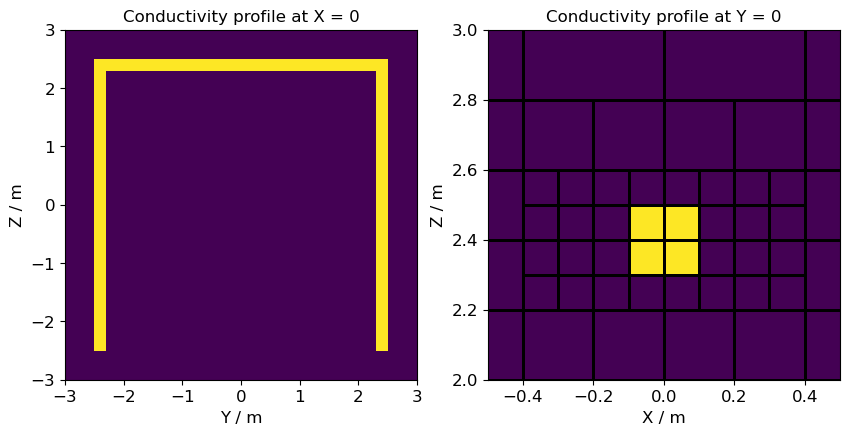

In [9]:
sigma_air = 1e-8
sigma_frame = 5e5
sigma_rail  = 1.25e6
sigma_half = round(1 / 300, 4)
sigma_block = [sigma_half, 1]
dir = ["x", "y", "z"]
mu_r = 100
offset = 0
distance = 50
thickness = 0.2
cell = [0.01, 0.025, 0.05, 0.1]
# cell = [0.01]
# path = "./data_Src{}_block{}_offset{}_distance{}.npy".format(dir[j], sigma_block[i], offset, distance)
mesh, source_locations, receiver_locations = mesh_d(offset, dir[0], distance, cell[2])
model, mur = get_model_frame_rail(mesh, sigma_half, sigma_frame, sigma_rail, mu_r, sigma_block[0], sigma_air, thickness)

In [10]:
mesh

OcTreeMesh,0.00% filled
Level,Number of cells
2,32
3,224
4,224
5,224
6,224
7,224
8,224
9,224
10,224


Calculating Initial fields
Factoring the system matrix for the DC problem
**************************************************
Calculating fields(m)
**************************************************
Factoring...   (dt = 1.000000e-07)
Done
    Solving...   (tInd = 1)
    Done...
    Solving...   (tInd = 2)
    Done...
    Solving...   (tInd = 3)
    Done...
    Solving...   (tInd = 4)
    Done...
    Solving...   (tInd = 5)
    Done...
    Solving...   (tInd = 6)
    Done...
    Solving...   (tInd = 7)
    Done...
    Solving...   (tInd = 8)
    Done...
    Solving...   (tInd = 9)
    Done...
    Solving...   (tInd = 10)
    Done...
    Solving...   (tInd = 11)
    Done...
    Solving...   (tInd = 12)
    Done...
    Solving...   (tInd = 13)
    Done...
    Solving...   (tInd = 14)
    Done...
    Solving...   (tInd = 15)
    Done...
    Solving...   (tInd = 16)
    Done...
    Solving...   (tInd = 17)
    Done...
    Solving...   (tInd = 18)
    Done...
    Solving...   (tInd = 19)
    

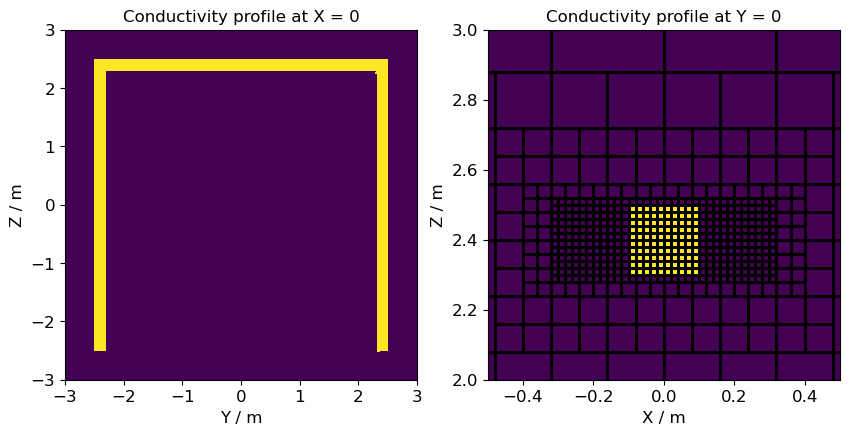

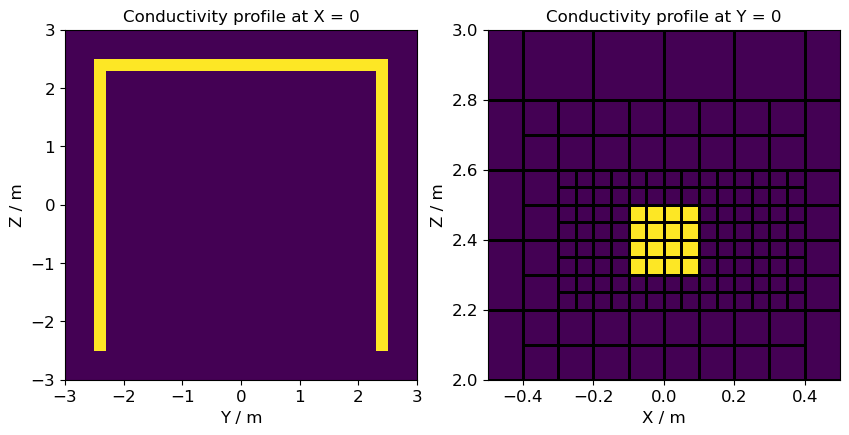

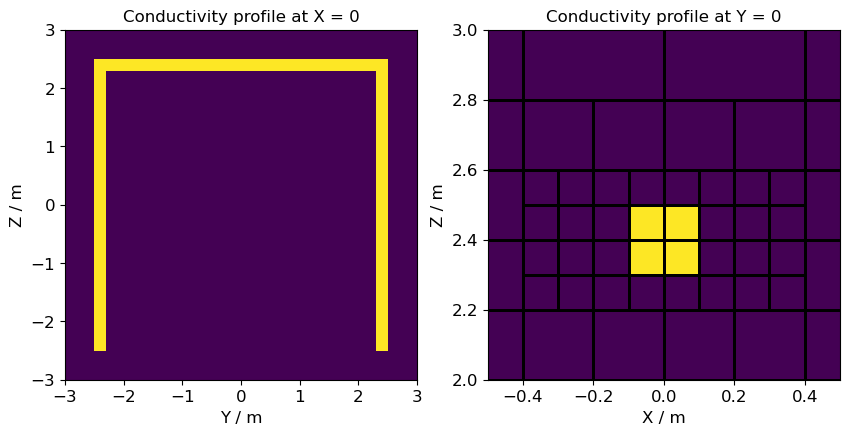

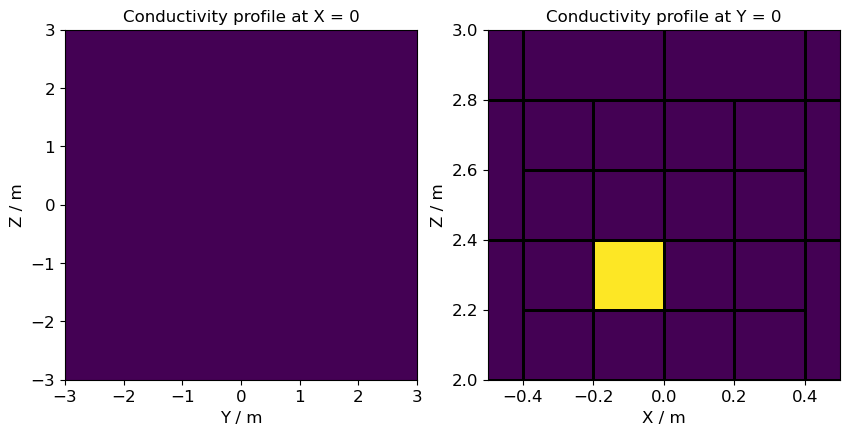

In [11]:
sigma_air = 1e-8
sigma_frame = 5e5
sigma_rail  = 1.25e6
sigma_half = round(1 / 300, 4)
sigma_block = sigma_half
mu_r = 1#100
offset = 0
distance = 50
thickness = 0.2
dir = ["x", "y", "z"]

# cell = [0.04, 0.05, 0.1]
cell = [0.01, 0.025, 0.05, 0.1]

for i in range(len(cell)):
    path = "./data_Src{}_cellSize{}.npy".format(dir[0], cell[i], thickness)
    mesh, source_locations, receiver_locations = mesh_d(offset, dir[0], distance, cell[i])
    model, mur = get_model_frame_rail(mesh, sigma_half, sigma_frame, sigma_rail, mu_r, sigma_block, sigma_air, thickness)
    forward(mesh, model, mur, source_locations, receiver_locations, path)

### Plot

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


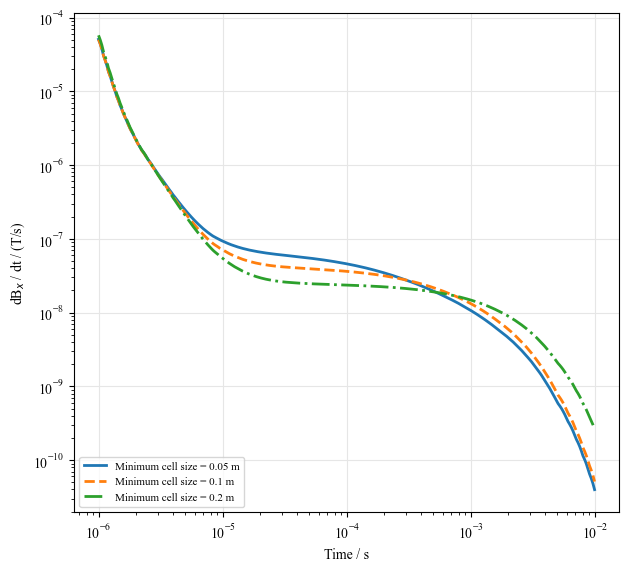

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

sigma_air = 1e-8
sigma_frame = 5e5
sigma_rail  = 1.25e6
sigma_half = round(1 / 300, 4)
sigma_block = sigma_half
mu_r = 100
offset = 0
distance = 50
dir = ["x", "y", "z"]

# cell = [0.01, 0.025, 0.05, 0.1]
cell = [0.025, 0.05, 0.1]
times = np.logspace(np.log10(1e-6), np.log10(1e-2), 300)

line = ['-', '--', '-.', ':']

dobs = []
for i in range(len(cell)):
    path = "./data_Src{}_cellSize{}.npy".format(dir[0], cell[i], 0.2)
    dobs.append(np.load(path).reshape(3, times.size))


fig = plt.figure(figsize=(12,6), dpi=100)
ax = plt.subplot(121)
plt.rcParams["font.family"] = ["Times New Roman", 'STFangsong']
label = ["Minimum cell size = "]

font = 10
for i in range(len(cell)):
    ax.loglog(times, np.abs(dobs[i][0]), 'C{}{}'.format(i, line[i]), label=label[0]+'{}'.format(cell[i]*2)+' m', lw = 2)

    # ax.text(0.88, 0.97, f"({chr(97+i)})", transform=ax.transAxes, fontsize=font, verticalalignment='top')
    ax.set_xlabel('Time / s', fontsize=font)
    ax.set_ylabel('dB$_{}$ / dt / (T/s)'.format(dir[0]), fontsize=font)
    ax.legend(loc=3, fontsize=8)
    ax.grid(True, c="0.9")
    ax.tick_params(axis='both', which='major', labelsize=font)

plt.tight_layout(rect=[0, 0.03, 1, 1])  # 调整布局以给图例留出空间
# plt.savefig('./data_fig6/Figure6.png', dpi=350, bbox_inches="tight")
plt.savefig('./CellSize.eps', dpi=350, bbox_inches="tight")